In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

The figures outputted by `wilcox_replication.py` don't completely match the results from one of the figures in the paper and the repo. The paper's figure had error bars, while we plotted the aggregate values. 

In [99]:
wilcox_results = pd.read_csv("fgd_learnability/data/combined_results.csv")
wilcox_results.head()

,token,word_idx,test,item,condition,region,NGRAM,JRNN,GPT2,GRNN,GPT3,sent_index.y
0,a,1,islands_left-branch,6.0,what_nogap_obj,compl_obj,7.578117,6.370591,3.889192,4.003127,5.733870,5.0
1,a,2,islands_left-branch,6.0,what_nogap_obj,det,4.381148,9.784269,6.762110,7.567266,7.003057,10.0
2,at,1,islands_left-branch,6.0,what_nogap_obj,continuation,8.266112,7.997192,4.781812,6.057877,5.468515,13.0
3,famous,1,islands_left-branch,6.0,what_nogap_obj,compl,16.049656,17.486204,9.678955,14.816560,9.376879,4.0
4,famous,2,islands_left-branch,6.0,what_nogap_obj,adj,15.842245,10.961686,7.109228,11.753505,6.323471,11.0


In [100]:
wilcox_results['test'].unique()

array(['islands_left-branch', 'basic_subject', 'basic_object', 'basic_pp',
       'islands_adjunct', 'islands_coordination', 'islands_cnp',
       'that_trace', 'embed4', 'embed3', 'embed2', 'embed1',
       'parasitic-gaps', 'islands_ss', 'islands_subject', 'islands_wh',
       'gender_adjunct', 'gender_sent-subj', 'gender_subj', 'gender_wh',
       'gender_cnp', 'gender_coord', nan, 'hierarchy'], dtype=object)

In [101]:
df_basic = wilcox_results[wilcox_results['test'].isin(['basic_subject', 'basic_object', 'basic_pp'])]
df_basic[['wh', 'gap']] = df_basic['condition'].str.split('_', expand=True)
df_basic = df_basic.melt(id_vars=['test', 'item', 'wh', 'gap', 'region'], value_vars=df_basic[['GPT2', 'GRNN']], var_name='model', value_name='surprisal')
df_basic = df_basic.groupby(['test', 'item', 'wh', 'gap', 'region', 'model']).agg({'surprisal': 'sum'}).reset_index()
df_basic['test'] = pd.Categorical(df_basic['test'], categories=["basic_subject", "basic_object", "basic_pp"])
df_basic = df_basic[df_basic['test'].isin(["basic_subject", "basic_object", "basic_pp"])]

conditions = [
    (df_basic['test'] == "basic_subject") & (df_basic['region'] == "verb") & (df_basic['gap'] == "gap"),
    (df_basic['test'] == "basic_subject") & (df_basic['region'] == "np1") & (df_basic['gap'] == "nogap"),
    (df_basic['test'] == "basic_object") & (df_basic['region'] == "prep") & (df_basic['gap'] == "gap"),
    (df_basic['test'] == "basic_object") & (df_basic['region'] == "np2") & (df_basic['gap'] == "nogap"),
    (df_basic['test'] == "basic_pp") & (df_basic['region'] == "end") & (df_basic['gap'] == "gap"),
    (df_basic['test'] == "basic_pp") & (df_basic['region'] == "np3") & (df_basic['gap'] == "nogap")
]

df_basic = df_basic[np.logical_or.reduce(conditions)]

df_basic = pd.pivot_table(df_basic, values='surprisal', index=['model', 'test', 'item', 'gap'], columns='wh').reset_index()
df_basic['whf'] = df_basic['what'] - df_basic['that']
df_basic = df_basic.drop(['that', 'what'], axis=1)

/var/folders/23/7hcv_qtd60j5mx97z8mfdjgh0000gn/T/ipykernel_22827/2731934115.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basic[['wh', 'gap']] = df_basic['condition'].str.split('_', expand=True)
/var/folders/23/7hcv_qtd60j5mx97z8mfdjgh0000gn/T/ipykernel_22827/2731934115.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_basic[['wh', 'gap']] = df_basic['condition'].str.split('_', expand=True)


In [177]:
avg = df_basic.groupby(['model', 'test', 'gap']).agg("mean")
avg = avg.reset_index()

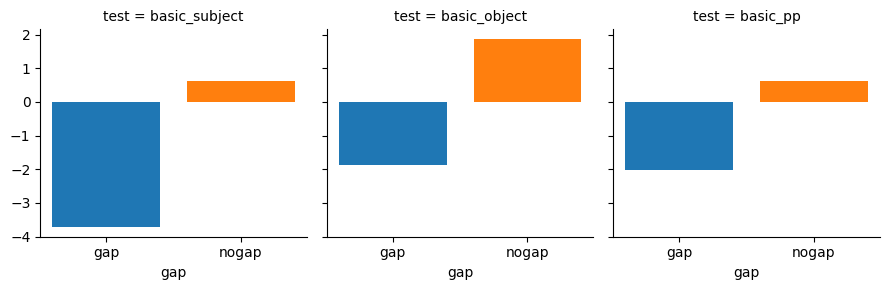

In [9]:
gpt2 = avg[avg['model'] == 'GPT2']
g = sns.FacetGrid(gpt2, col="test", hue="gap")
g.map_dataframe(plt.bar, x = 'gap', height= 'whf')

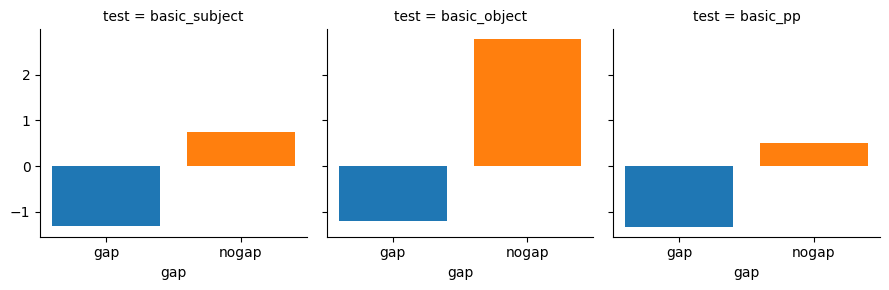

In [178]:
grnn = avg[avg['model'] == 'GRNN']
g = sns.FacetGrid(grnn, col="test", hue="gap")
g.map_dataframe(plt.bar, x = 'gap', height= 'whf')

In [18]:
df_basic

wh,model,test,item,gap,whf
0,GPT2,basic_subject,1.0,gap,-3.834650
1,GPT2,basic_subject,1.0,nogap,0.070066
2,GPT2,basic_subject,2.0,gap,-3.629212
3,GPT2,basic_subject,2.0,nogap,1.030886
4,GPT2,basic_subject,3.0,gap,0.107743
...,...,...,...,...,...
595,GRNN,basic_pp,48.0,nogap,0.853009
596,GRNN,basic_pp,49.0,gap,-2.637016
597,GRNN,basic_pp,49.0,nogap,1.620522
598,GRNN,basic_pp,50.0,gap,-0.446457


In [21]:
gpt2 = df_basic[df_basic['model'] == 'GPT2']
gpt2.groupby(['test', 'gap']).agg({"whf": "mean"})

wh                        whf
test          gap            
basic_subject gap   -3.725968
              nogap  0.610327
basic_object  gap   -1.863969
              nogap  1.878282
basic_pp      gap   -2.024417
              nogap  0.612587

In [22]:
gpt2.groupby(['test', 'gap']).agg({"whf": "max"})

wh                        whf
test          gap            
basic_subject gap    2.699320
              nogap  5.123085
basic_object  gap    0.437001
              nogap  5.390547
basic_pp      gap    0.442867
              nogap  3.572443

In [23]:
gpt2.groupby(['test', 'gap']).agg({"whf": "min"})

wh                        whf
test          gap            
basic_subject gap   -8.893178
              nogap -5.010052
basic_object  gap   -4.636126
              nogap  0.047405
basic_pp      gap   -5.113097
              nogap -0.921090

Comparison with our values

In [33]:
import json
import os

In [174]:
basic_results = [os.path.join("grammar_outputs", "wilcox_replication", result)
  for result in os.listdir("grammar_outputs/wilcox_replication/") if any(condition in result for condition in ["subject", "object", "pp"])]
basic_data = []
for output in basic_results:
    construction_data = json.load(open(output))
    stim_id = 1
    model_name = output.split(".json")[0][-4:]
    construction_name = output.split(".json")[0].split("/")[2].split("_")[1]
    for stim_set in construction_data:
        base_info = {"item": stim_id, "model": model_name, 'test': construction_name}
        base_info2 = base_info.copy()
        base_info['wh_effect'] = stim_set['s_ab']['critical_surprisal'] - stim_set['s_xb']['critical_surprisal']
        base_info['gap'] = 'gap'
        basic_data.append(base_info)
        base_info2['wh_effect'] = stim_set['s_ax']['critical_surprisal'] - stim_set['s_xx']['critical_surprisal']
        base_info2['gap'] = 'nogap'
        basic_data.append(base_info2)
        stim_id +=1

In [175]:
replication_basic = pd.DataFrame(basic_data)
avg = replication_basic.groupby(['model', 'test', 'gap']).agg("mean")
avg = avg.reset_index()
avg

,model,test,gap,item,wh_effect
0,gpt2,object,gap,25.5,-1.878210
1,gpt2,object,nogap,25.5,4.185254
2,gpt2,pp,gap,25.5,-2.628220
3,gpt2,pp,nogap,25.5,1.627942
4,gpt2,subject,gap,25.5,-3.608815
5,gpt2,subject,nogap,25.5,3.477370
6,grnn,object,gap,25.5,-0.389012
7,grnn,object,nogap,25.5,3.369370
8,grnn,pp,gap,25.5,-1.294981
9,grnn,pp,nogap,25.5,1.259664


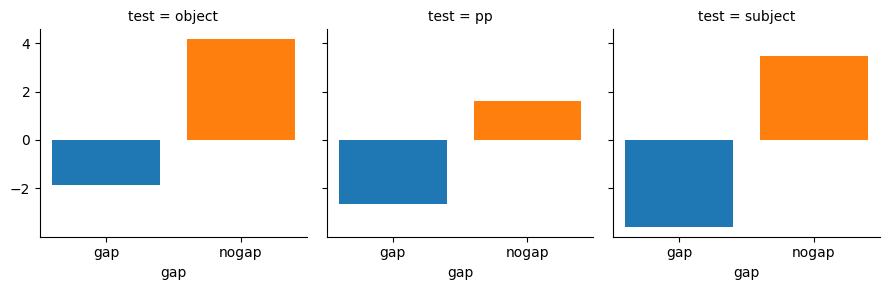

In [95]:
gpt2 = avg[avg['model'] == 'gpt2']
g = sns.FacetGrid(gpt2, col="test", hue="gap")
g.map_dataframe(plt.bar, x = 'gap', height= 'wh_effect')

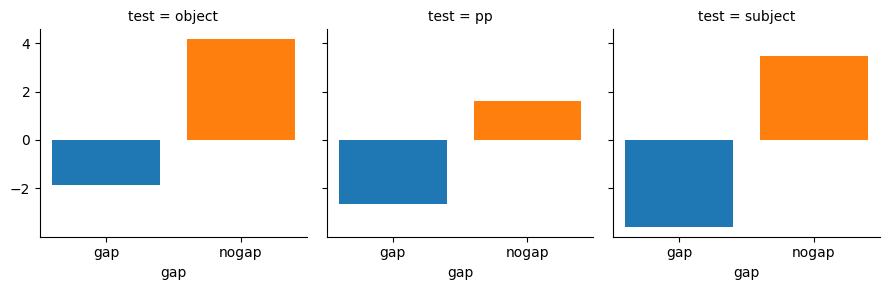

In [176]:
grnn = avg[avg['model'] == 'grnn']
g = sns.FacetGrid(gpt2, col="test", hue="gap")
g.map_dataframe(plt.bar, x = 'gap', height= 'wh_effect')

In [135]:
np.mean(replication_basic[replication_basic['model'] == 'gpt2']['wh_effect'].values - df_basic[df_basic['model'] == 'GPT2']['whf'].values)

0.9480799092336886

Mean difference of surprisal values (GPT2)

In [124]:
np.mean(replication_basic[replication_basic['model'] == 'gpt2']['wh_effect'].values
         - df_basic[df_basic['model'] == 'GPT2']['whf'].values)

0.9480799092336886

In [133]:
df_basic[df_basic['test'] == 'basic_subject'][:2]

wh,model,test,item,gap,whf
0,GPT2,basic_subject,1.0,gap,-3.834650
1,GPT2,basic_subject,1.0,nogap,0.070066


In [140]:
replication_basic[(replication_basic['test'] == 'subject') & (replication_basic['model'] == 'gpt2')][:2]

,item,model,test,wh_effect,gap
198,1,gpt2,subject,-5.526525,gap
199,1,gpt2,subject,0.106689,nogap


In [162]:
from surprisal import align_surprisal

In [170]:
wilcox_results[(wilcox_results['test'] == 'basic_subject') & (wilcox_results['token'] == 'grabbed')]

,token,word_idx,test,item,condition,region,NGRAM,JRNN,GPT2,GRNN,GPT3,sent_index.y
14658,grabbed,1,basic_subject,1.0,that_gap,verb,16.491387,19.199198,13.227647,18.517796,14.526399,7.0
14717,grabbed,3,basic_subject,1.0,that_nogap,verb,16.981642,13.383256,9.125727,16.727510,8.972041,9.0
18917,grabbed,1,basic_subject,1.0,what_gap,verb,16.491387,12.786845,9.392996,16.046219,8.688656,7.0
18955,grabbed,2,basic_subject,1.0,what_nogap,verb,16.981642,13.760231,10.180616,17.875113,9.012871,9.0


In [173]:
replication_basic[(replication_basic['item'] == 1) & (replication_basic['test'] == 'subject')]

,item,model,test,wh_effect,gap
100,1,grnn,subject,0.882647,gap
101,1,grnn,subject,0.413425,nogap
198,1,gpt2,subject,-5.526525,gap
199,1,gpt2,subject,0.106689,nogap


In [141]:
stims = pd.read_csv("data/wilcox_csv/basic_subject.csv")
stims[:4]

,item,condition,prefix,comp,apposotive,np1,verb,np2,prep,np3,end
0,1,what_nogap,I know,who,with gusto,our uncle,grabbed,the food,in front of,the guests,at the holiday party
1,1,that_nogap,I know,that,with gusto,our uncle,grabbed,the food,in front of,the guests,at the holiday party
2,1,what_gap,I know,who,with gusto,NaN,grabbed,the food,in front of,the guests,at the holiday party
3,1,that_gap,I know,that,with gusto,NaN,grabbed,the food,in front of,the guests,at the holiday party


In [152]:
s_ab = "I know who with gusto our uncle grabbed the food in front of the guests at the holiday party"
s_ax = "I know who with gusto our uncle grabbed the food in front of the guests at the holiday party"
s_xb = "I know that with gusto grabbed the food in front of the guests at the holiday party"
s_xx = "I know who with gusto grabbed the food in front of the guests at the holiday party"

In [164]:
[result[1] for result in gpt2_surprisal(s_ab) if result[0] == 'grabbed']

[14.797761917114258]

In [165]:
[result[1] for result in gpt2_surprisal(s_xb) if result[0] == 'grabbed']

[19.175134658813477]